In [1]:
import cv2
import numpy as np
import base64

In [2]:
def crop_face(image):
    # Load the pre-trained face detection model
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    
    # Convert the image to grayscale for face detection
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Detect faces in the image
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
    
    # If no faces are detected, return None
    if len(faces) == 0:
        print("Error: No face detected in the input image.")
        return None
    
    # Extend the bounding box to include more of the head and hair region
    x, y, w, h = faces[0]
    extended_x = max(0, x - int(0.2 * w))
    extended_y = max(0, y - int(0.2 * h))
    extended_w = min(image.shape[1] - extended_x, int(1.4 * w))
    extended_h = min(image.shape[0] - extended_y, int(1.4 * h))
    
    # Crop the image to include the extended face region
    cropped_face = image[extended_y:extended_y+extended_h, extended_x:extended_x+extended_w]
    
    return cropped_face

In [3]:
def create_passport_photo(image):
    # Check if a face is detected
    if image is None:
        print("Error: Cannot create passport photo because no face was detected.")
        return None
    
    # Define the size of the passport photo
    passport_size = (80, 100)
    
    # Calculate the aspect ratio of the cropped face
    face_aspect_ratio = image.shape[1] / image.shape[0]
    
    # Define the aspect ratio of the head and shoulder portion in the passport photo
    head_shoulder_aspect_ratio = passport_size[0] / passport_size[1]
    
    # Determine the scaling factor based on the aspect ratios
    if face_aspect_ratio > head_shoulder_aspect_ratio:
        # Scale based on width
        scale_factor = passport_size[0] / image.shape[1]
    else:
        # Scale based on height
        scale_factor = passport_size[1] / image.shape[0]
    
    # Resize the image to fit the head and shoulder portion
    resized_image = cv2.resize(image, None, fx=scale_factor, fy=scale_factor)
    
    # Create a white background image with the same size as the passport photo
    white_background = np.full((passport_size[1], passport_size[0], 3), 255, dtype=np.uint8)
    
    # Calculate the position to paste the resized face onto the white background
    x_offset = (passport_size[0] - resized_image.shape[1]) // 2
    y_offset = (passport_size[1] - resized_image.shape[0]) // 2
    
    # Paste the resized face onto the white background
    white_background[y_offset:y_offset+resized_image.shape[0], x_offset:x_offset+resized_image.shape[1]] = resized_image
    
    return white_background

In [4]:
def process_image(image_data_uri):
    # Decode the base64-encoded image data
    encoded_data = image_data_uri.split(',')[1]
    decoded_data = base64.b64decode(encoded_data)
    nparr = np.frombuffer(decoded_data, np.uint8)

    # Read the image from the decoded data
    image = cv2.imdecode(nparr, cv2.IMREAD_COLOR)

    # Crop the detected face from the image
    cropped_face = crop_face(image)
    
    # Create the passport photo from the cropped face
    passport_photo = create_passport_photo(cropped_face)

    # Encode the processed image to base64 format
    _, buffer = cv2.imencode('.png', passport_photo)
    output_image_data_uri = 'data:image/png;base64,' + base64.b64encode(buffer).decode()

    return output_image_data_uri


In [5]:
from matplotlib import pyplot as plt
# Function to display the original and processed images
def display_images(original_image, processed_image):
    plt.figure(figsize=(10, 5))
    
    # Display original image
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
    plt.title('Original Image')
    plt.axis('off')
    
    # Display processed image
    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(processed_image, cv2.COLOR_BGR2RGB))
    plt.title('Processed Image')
    plt.axis('off')
    
    plt.show()

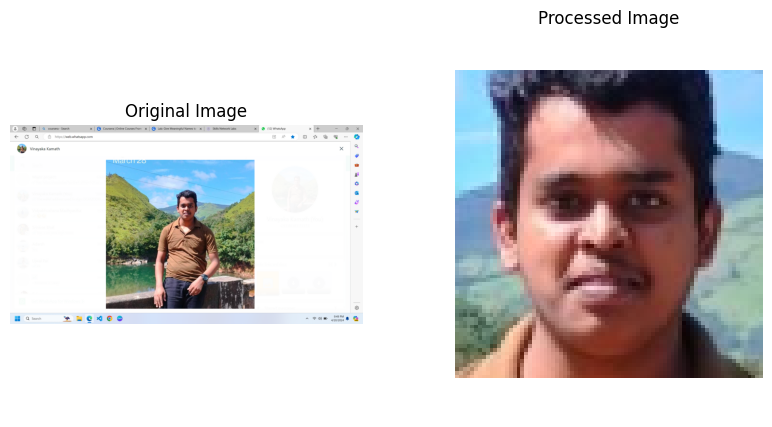

In [6]:
image_path = 'profileImages/Vinayaka.png'  # Replace with the path to your local image file
original_image = cv2.imread(image_path)

# Process the image
cropped_face = crop_face(original_image)
processed_image = create_passport_photo(cropped_face)

# Display images
display_images(original_image, processed_image)